In [1]:
import warnings
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio import Seq
from Bio.Align.Applications import MuscleCommandline
from Bio.Align.Applications import ClustalwCommandline
from Bio import Phylo
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.Consensus import *

warnings.filterwarnings('ignore')
random.seed(213)

In [2]:
species_dict = {
    1: ("Cycas revoluta", "Cycadaceae"),
    2: ("Ginkgo biloba", "Ginkgoaceae"),
    3: ("Ephedra sinica", "Ephedraceae"),
    4: ("Larix decidua", "Pinaceae"),
    5: ("Gnetum gnemon", "Gnetaceae"),
    6: ("Welwitschia mirabilis", "Welwitschiaceae"),
    7: ("Sciadopitys verticillata", "Sciadopityaceae"),
    8: ("Juniperus communis", "Cupressaceae"),
    9: ("Araucaria angustifolia", "Araucariaceae"),
    10: ("Nageia nagi", "Podocarpaceae"),
    11: ("Zamia furfuracea", "Zamiaceae"), 
    12: ("Taxus baccata", "Taxaceae")
}

n_species = 12

# Data preparation

## Data exploration

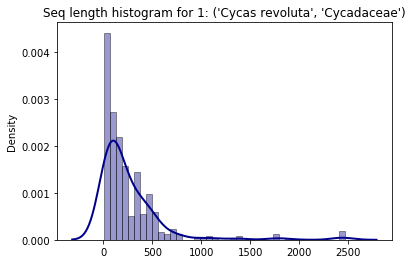

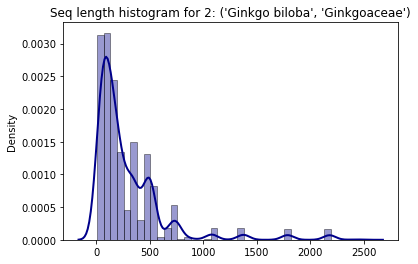

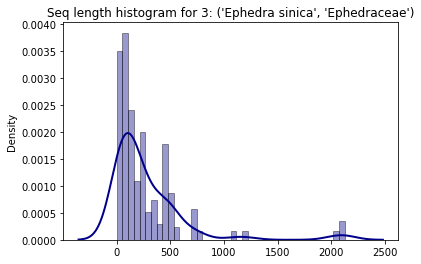

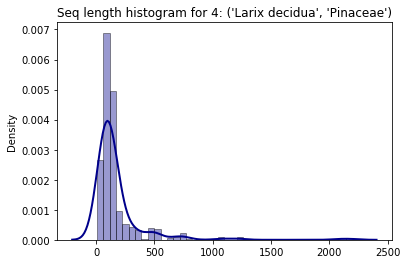

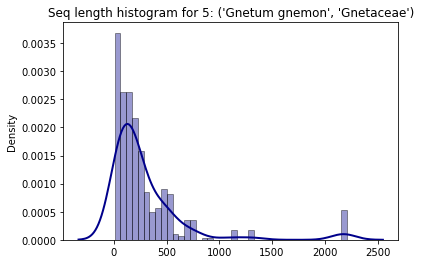

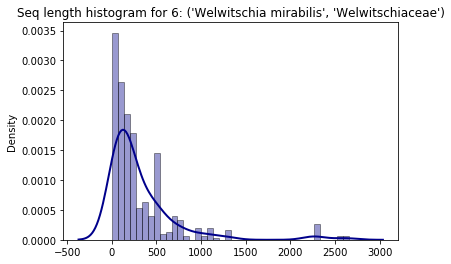

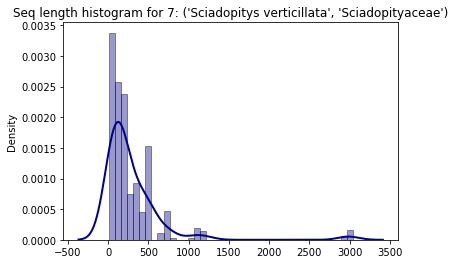

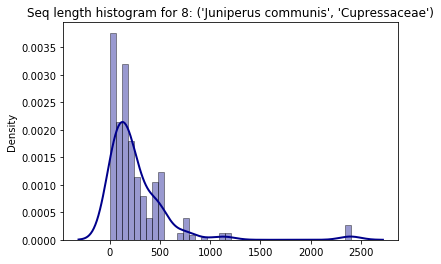

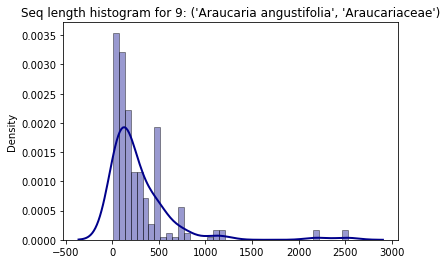

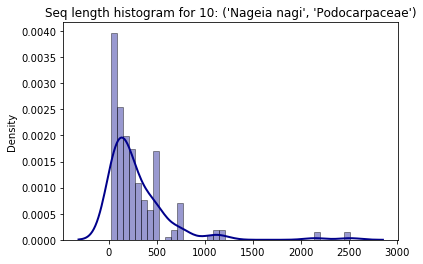

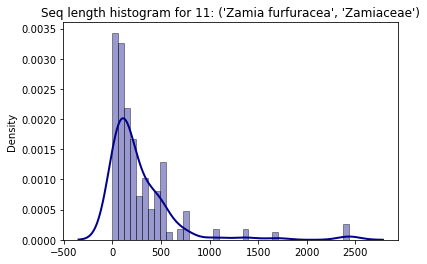

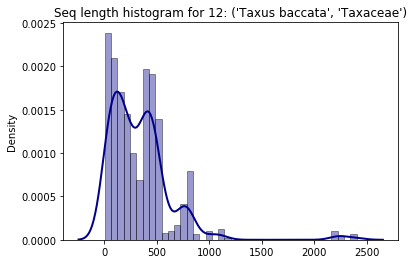

In [3]:
for i in range(1, n_species + 1):
    records = list(SeqIO.parse("seqs/downloaded/" + str(i) + ".fasta", "fasta"))
    lens = []
    for record in records:
        lens.append(len(record))
    sns.distplot(np.array(lens), hist=True, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
    plt.title("Seq length histogram for " + str(i) + ": " + str(species_dict.get(i)))
    plt.show()

In [4]:
for i in range(1, n_species + 1):
    records = list(SeqIO.parse("seqs/downloaded/" + str(i) + ".fasta", "fasta"))
    lens = []
    for record in records:
        lens.append(len(record))
    min_len = 20
    max_len = 1000
    count = sum(1 for l in lens if l >= min_len and l <= max_len)
    print("selected seqs in " + str(i) + " " + str(species_dict.get(i)) + " : " + str(count))

selected seqs in 1 ('Cycas revoluta', 'Cycadaceae') : 361
selected seqs in 2 ('Ginkgo biloba', 'Ginkgoaceae') : 7979
selected seqs in 3 ('Ephedra sinica', 'Ephedraceae') : 305
selected seqs in 4 ('Larix decidua', 'Pinaceae') : 486
selected seqs in 5 ('Gnetum gnemon', 'Gnetaceae') : 487
selected seqs in 6 ('Welwitschia mirabilis', 'Welwitschiaceae') : 429
selected seqs in 7 ('Sciadopitys verticillata', 'Sciadopityaceae') : 443
selected seqs in 8 ('Juniperus communis', 'Cupressaceae') : 345
selected seqs in 9 ('Araucaria angustifolia', 'Araucariaceae') : 268
selected seqs in 10 ('Nageia nagi', 'Podocarpaceae') : 324
selected seqs in 11 ('Zamia furfuracea', 'Zamiaceae') : 360
selected seqs in 12 ('Taxus baccata', 'Taxaceae') : 759


In [5]:
for i in range(1, n_species + 1):
    records = list(SeqIO.parse("seqs/downloaded/" + str(i) + ".fasta", "fasta"))
    lens = []
    for record in records:
        lens.append(len(record))
    print(sum(lens) / len(lens))

261.50961538461536
290.20598759541986
282.322188449848
171.95922330097088
295.27659574468083
323.9518599562363
293.8199152542373
266.9238845144357
291.92657342657344
301.2823529411765
284.14882506527414
337.0261519302615


## Sequence selection

In [6]:
min_len = 20
max_len = 1000
for i in range(1, n_species + 1):
    records = list(SeqIO.parse("seqs/downloaded/" + str(i) + ".fasta", "fasta"))
    
    #filtering
    records2 = list()
    for record in records:
        if len(record) >= min_len and len(record) <= max_len:
            records2.append(record)
    records = random.sample(records2, min(250, len(records2)))
    
    # changing id to better identify them in the future
    for j in range(0, len(records)):
        records[j].id = str(i) + "_" + str(j + 1)
        
    SeqIO.write(records, "seqs/selected/" + str(i) + ".fasta", "fasta")

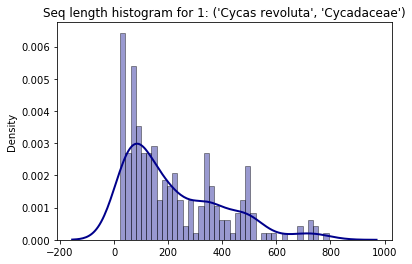

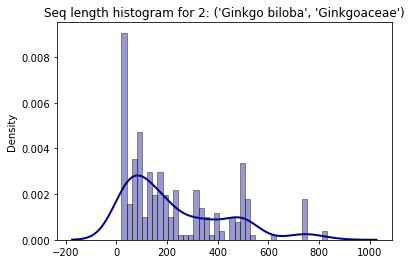

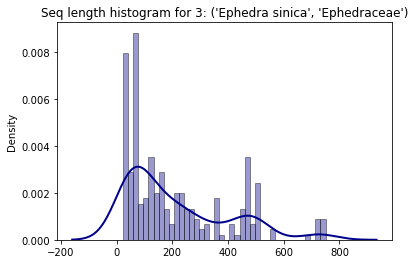

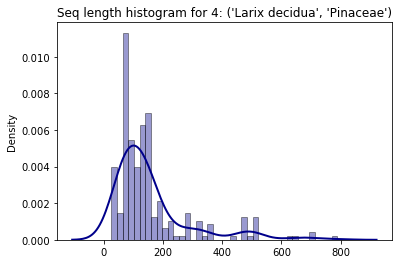

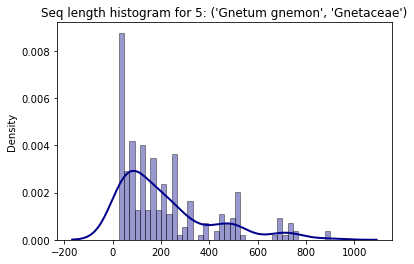

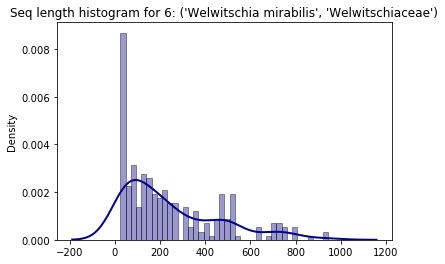

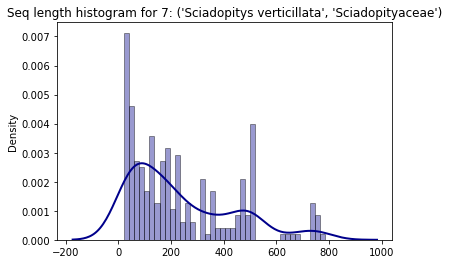

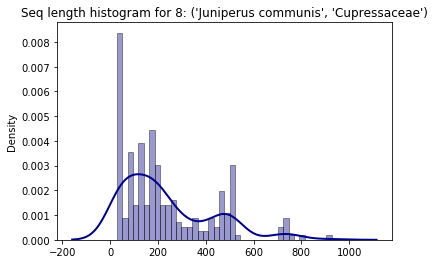

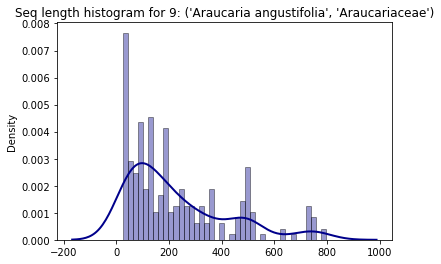

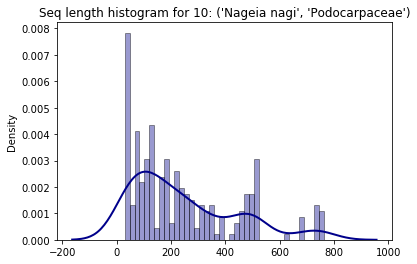

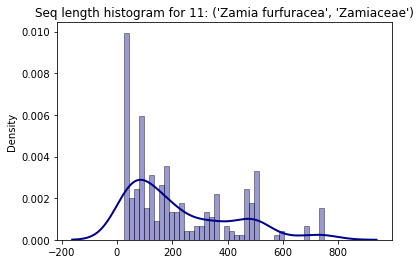

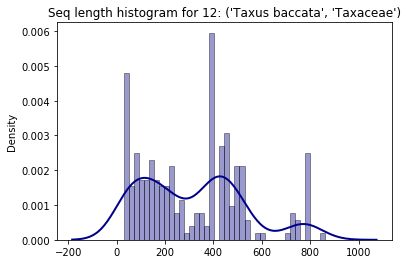

In [7]:
for i in range(1, n_species + 1):
    records = list(SeqIO.parse("seqs/selected/" + str(i) + ".fasta", "fasta"))
    lens = []
    for record in records:
        lens.append(len(record))
    sns.distplot(np.array(lens), hist=True, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
    plt.title("Seq length histogram for " + str(i) + ": " + str(species_dict.get(i)))
    plt.show()

### merging selected sequences

In [8]:
merged = list()
for i in range(1, n_species + 1):
    records = list(SeqIO.parse("seqs/selected/" + str(i) + ".fasta", "fasta"))
    merged = merged + records
    
SeqIO.write(merged, "seqs/merged.fasta", "fasta")

3000

In [9]:
len(merged)

3000

# Clustering - CD-HIT

### running algorithm

In [10]:
binary_path = "../cd-hit-v4.8.1-2019-0228/cd-hit" # path to cd-hit executable
input_path = "seqs/merged.fasta"
output_path = "clustering_results/cd-hit/clusters"
threshold = 0.6
wordsize = 4

command = "./" + binary_path + " -i " + input_path + " -o " + output_path + \
" -c " + str(threshold) + " -n " + str(wordsize)

os.system(command)

0

### reading results

In [11]:
class Cluster:
    def __init__(self):
        self.elems = list()
        
    def add(self, id1, id2):
        self.elems.append((id1, id2))
    
    def ids1(self):
        res = list()
        for pair in self.elems:
            res.append(pair[0])
        return res
    
    def cleaned(self):
        cluster2 = Cluster()
        for elem in self.elems:
            if elem[0] not in cluster2.ids1():
                cluster2.add(elem[0], elem[1])
        return cluster2
    
    def idsfull(self):
        res = list()
        for pair in self.elems:
            res.append(str(pair[0]) + "_" + str(pair[1]))
        return res
    

In [12]:
clusters = list()
with open(output_path + ".clstr", 'r') as file:
    for line in file:
        if line.startswith(">"):
            clusters.append(Cluster())
        else:
            id1 = line[(line.index(">") + 1):line.index("_")]
            id2 = line[(line.index("_") + 1):line.index("...")]
            clusters[-1].add(int(id1), int(id2))

In [13]:
len(clusters)

371

In [14]:
clusters2 = list()
for cluster in clusters:
    if all(x in cluster.ids1() for x in range(1, 11)):
        print(cluster.ids1())
        clusters2.append(cluster)

[1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12]
[1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12]
[1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[1, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12]
[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8, 9, 9, 9, 10, 10, 11, 11, 12]
[1, 2, 2, 2, 3, 3, 3, 4, 5, 

In [15]:
len(clusters2)

29

In [16]:
clusters3 = list()
for cluster in clusters2:
    filtered = cluster.cleaned()
    #print(filtered.idsfull())
    clusters3.append(filtered)

In [17]:
cseqs = list()
n_seqs = 0
for cluster in clusters3:
    cseq = list()
    n_seqs += 1
    for seq in merged:
        if seq.id in cluster.idsfull():
            cseq.append(seq)
    cseqs.append(cseq)
    SeqIO.write(cseq, "clustering_results/clusts/" + str(n_seqs) + ".fasta", "fasta")

In [18]:
for cseq in cseqs:
    lens = []
    for s in cseq:
        lens.append(len(s))
    print(sum(lens) / len(lens))

507.4166666666667
495.3333333333333
475.3333333333333
371.5
450.0
320.4166666666667
251.83333333333334
248.41666666666666
215.0
184.72727272727272
149.66666666666666
167.08333333333334
168.75
137.58333333333334
126.58333333333333
110.63636363636364
122.0
99.58333333333333
80.16666666666667
81.0
81.0
43.666666666666664
43.0
38.833333333333336
39.0
36.583333333333336
38.0
37.0
29.0


# MSA inside clusters

### Muscle

In [19]:
def run_muscle(n_seqs):
    cline = MuscleCommandline(input="clustering_results/clusts/" + str(n_seqs) + ".fasta", \
                          out="clustering_results/muscle/" + str(n_seqs) + ".aln")
    os.system(str(cline))

In [20]:
for i in range(1, n_seqs + 1):
    run_muscle(i)

### ClustalW

In [21]:
def run_clustal(n_seqs):
    cline = ClustalwCommandline("clustalw2", infile="clustering_results/clusts/" + str(n_seqs) + ".fasta", \
                               outfile="clustering_results/clustalw/" + str(n_seqs) + ".aln")
    os.system(str(cline))
    os.system("mv " + "clustering_results/clusts/" + str(n_seqs) + ".dnd" + " " \
              + "clustering_results/clustalw/" + str(n_seqs) + ".dnd")

In [22]:
for i in range(1, n_seqs + 1):
    run_clustal(i)

### guide trees produced by ClustalW

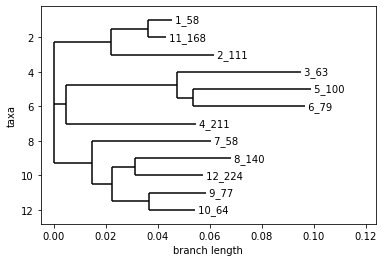

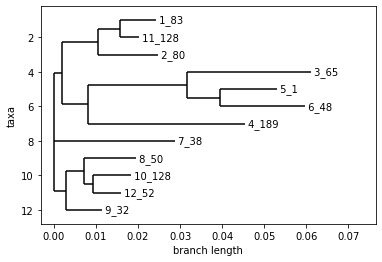

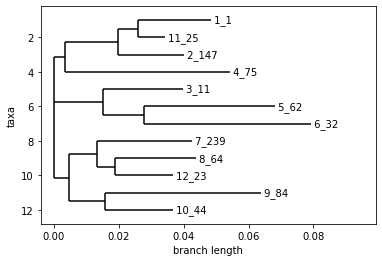

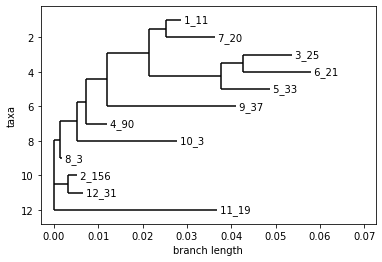

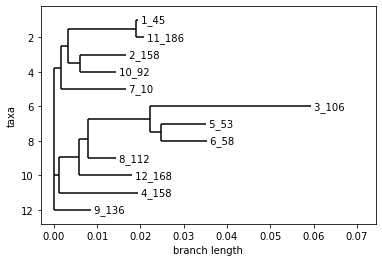

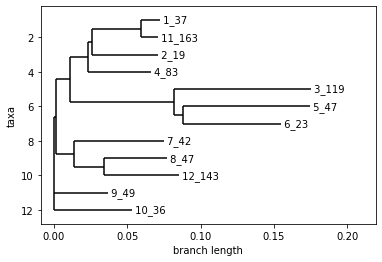

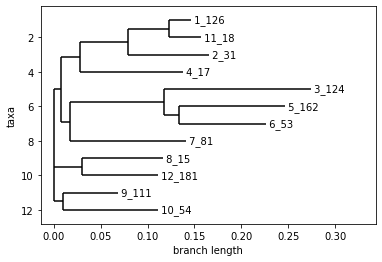

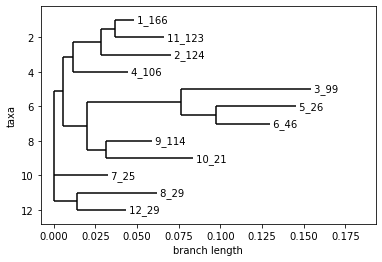

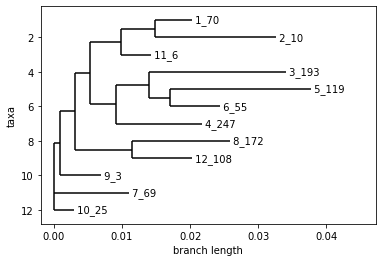

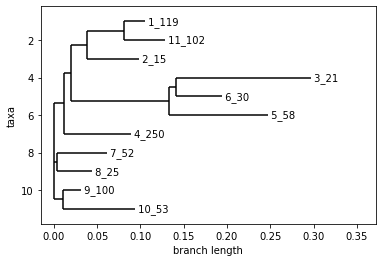

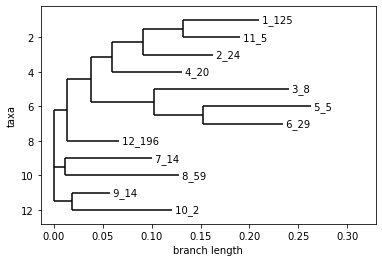

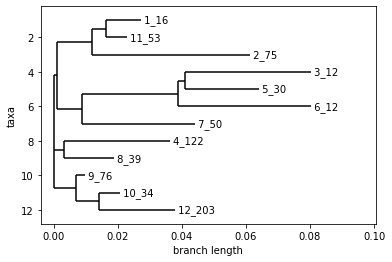

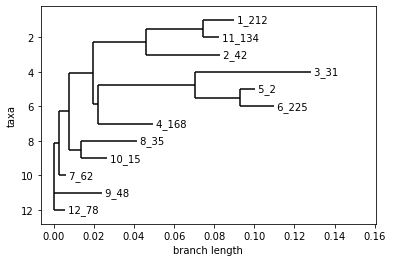

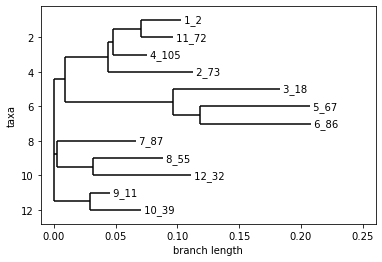

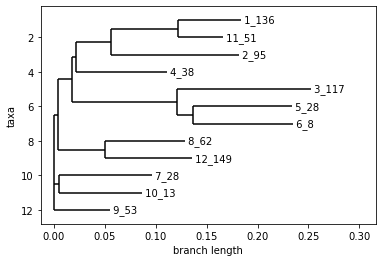

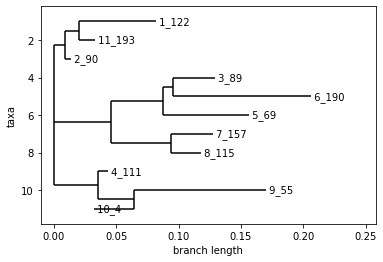

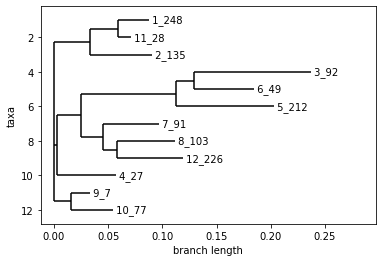

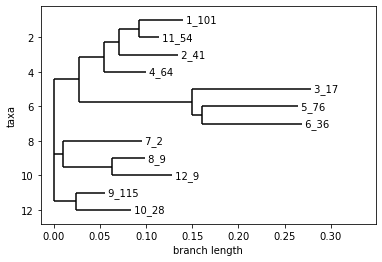

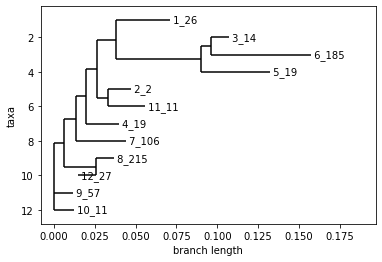

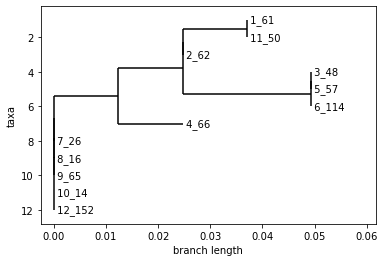

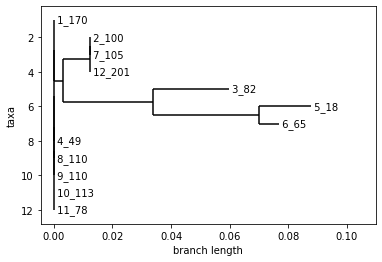

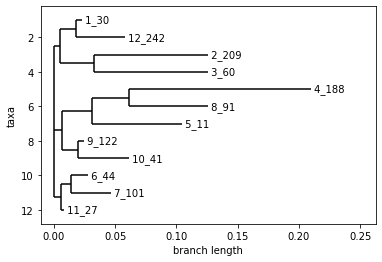

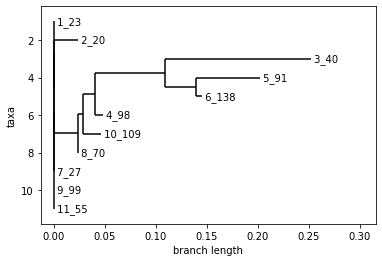

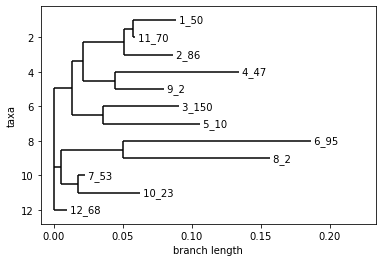

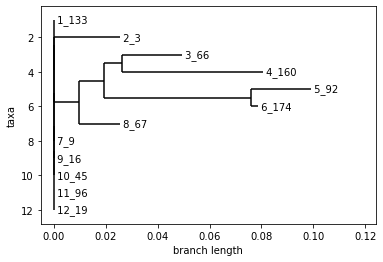

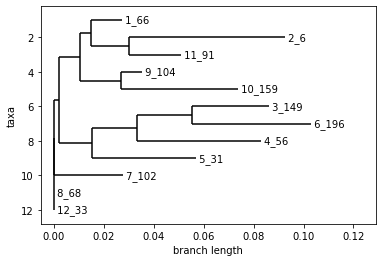

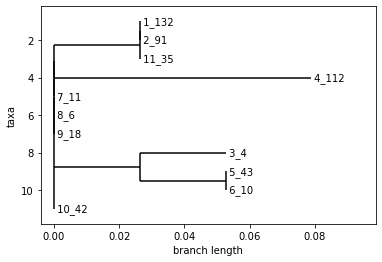

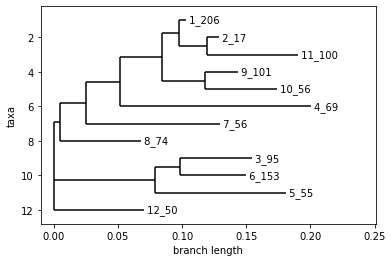

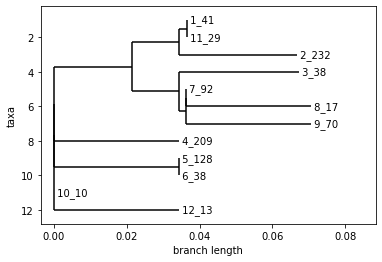

In [23]:
for i in range(1, n_seqs + 1):
    tree = Phylo.read("clustering_results/clustalw/" + str(i) + ".dnd", "newick")
    Phylo.draw(tree)

# Building phylogenetic trees

In [31]:
constructor = DistanceTreeConstructor()
calculator = DistanceCalculator('blosum62') # try different models maybe 
# protein_models = ['blosum45', 'blosum50', 'blosum62', 'blosum80', 'blosum90', 'pam250', 'pam30', 'pam70']

def build_tree_clustalw(i):
    aln = AlignIO.read("clustering_results/clustalw/" + str(i) + ".aln", "clustal")
    dm = calculator.get_distance(aln)
    return constructor.upgma(dm)

def build_tree_muscle(i):
    aln = AlignIO.read("clustering_results/muscle/" + str(i) + ".aln", "fasta")
    dm = calculator.get_distance(aln)
    return constructor.upgma(dm)

def label_display(label):
    if not label.name:
        return None
    elif label.name.startswith("Inner"):
        return ""
    else:
        number = int(label.name[:label.name.index("_")])
        return species_dict.get(number)[1]


### ClustalW trees

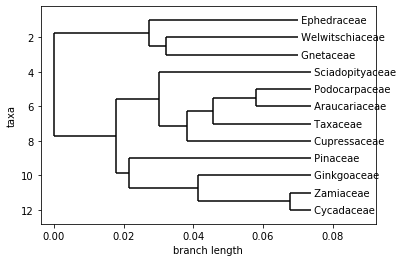

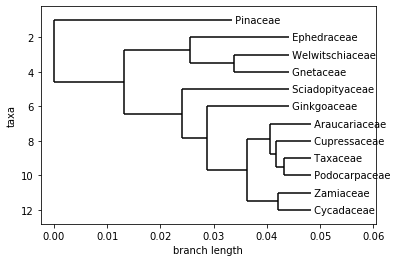

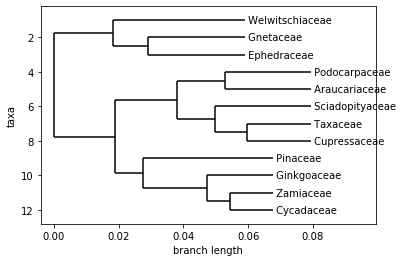

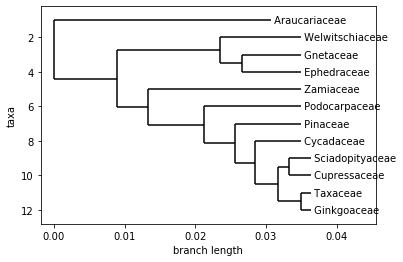

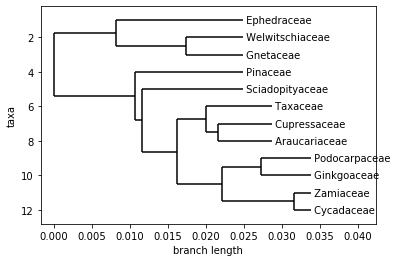

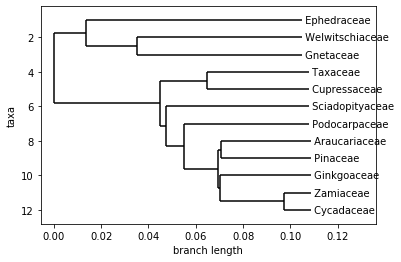

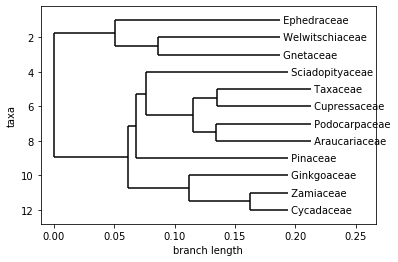

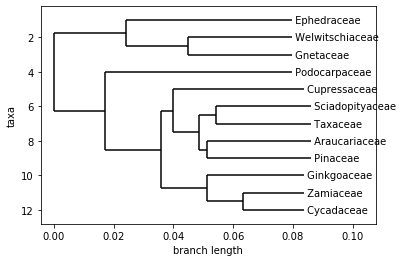

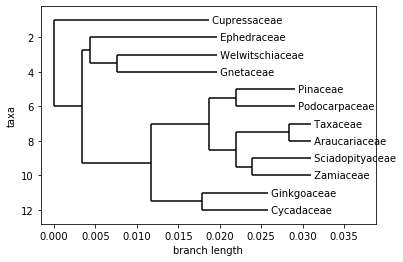

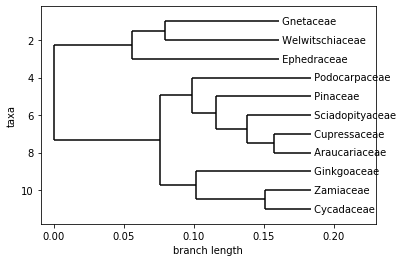

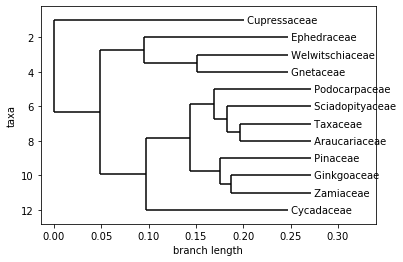

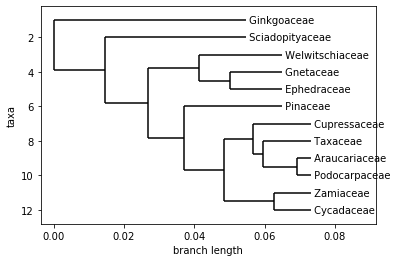

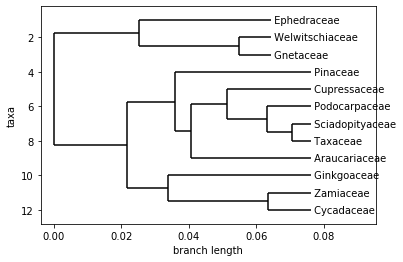

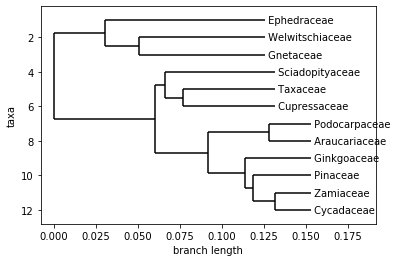

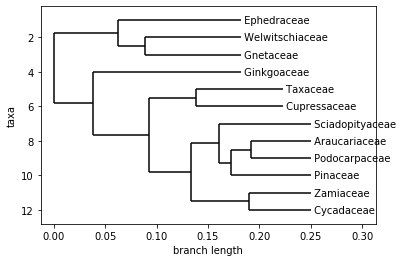

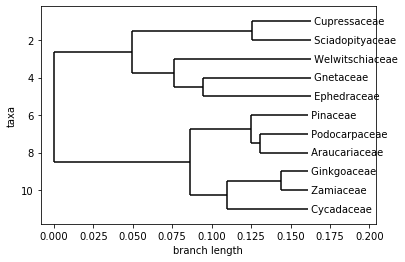

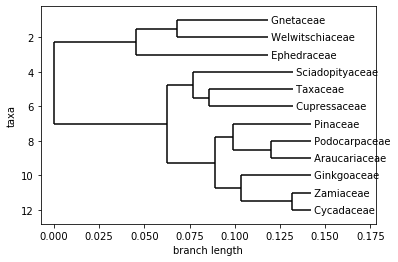

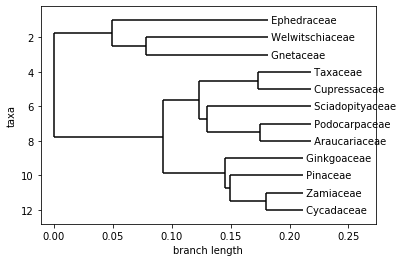

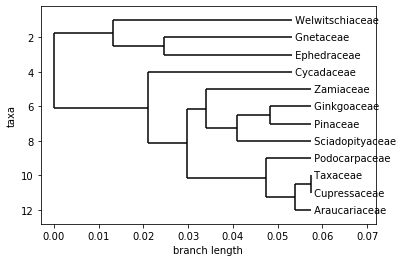

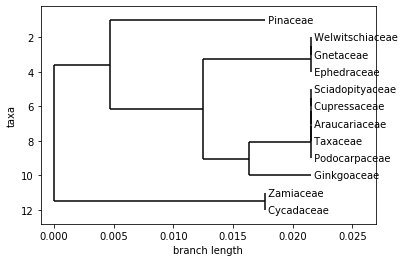

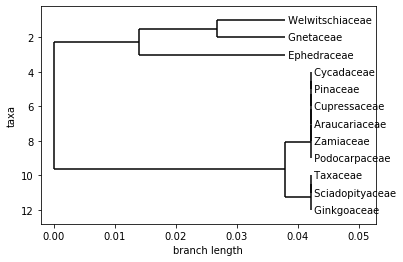

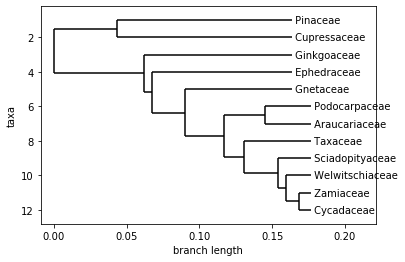

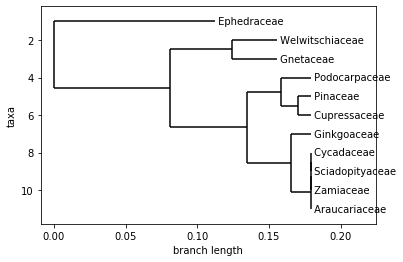

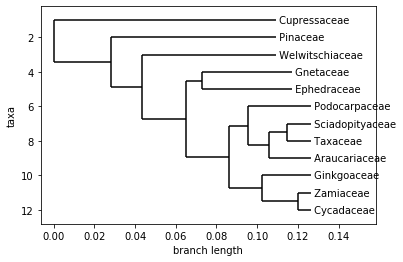

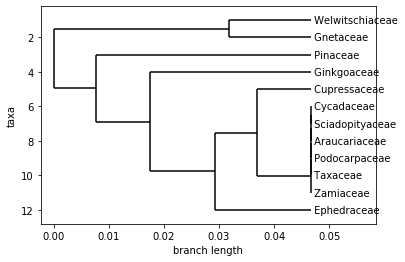

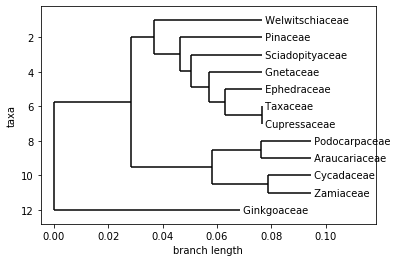

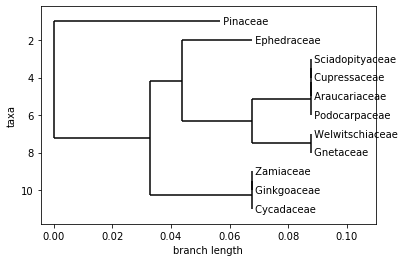

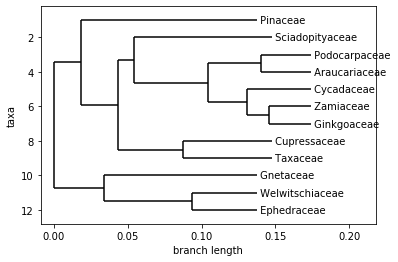

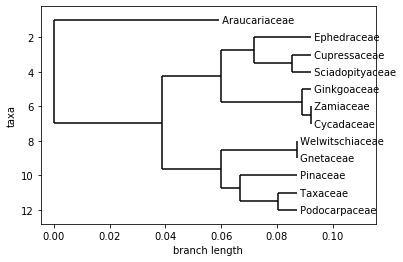

In [32]:
clustal_trees = list()
for i in range(1, n_seqs + 1):
    tree = build_tree_clustalw(i)
    clustal_trees.append(tree)
    Phylo.draw(tree, label_func=label_display)

### Muscle trees

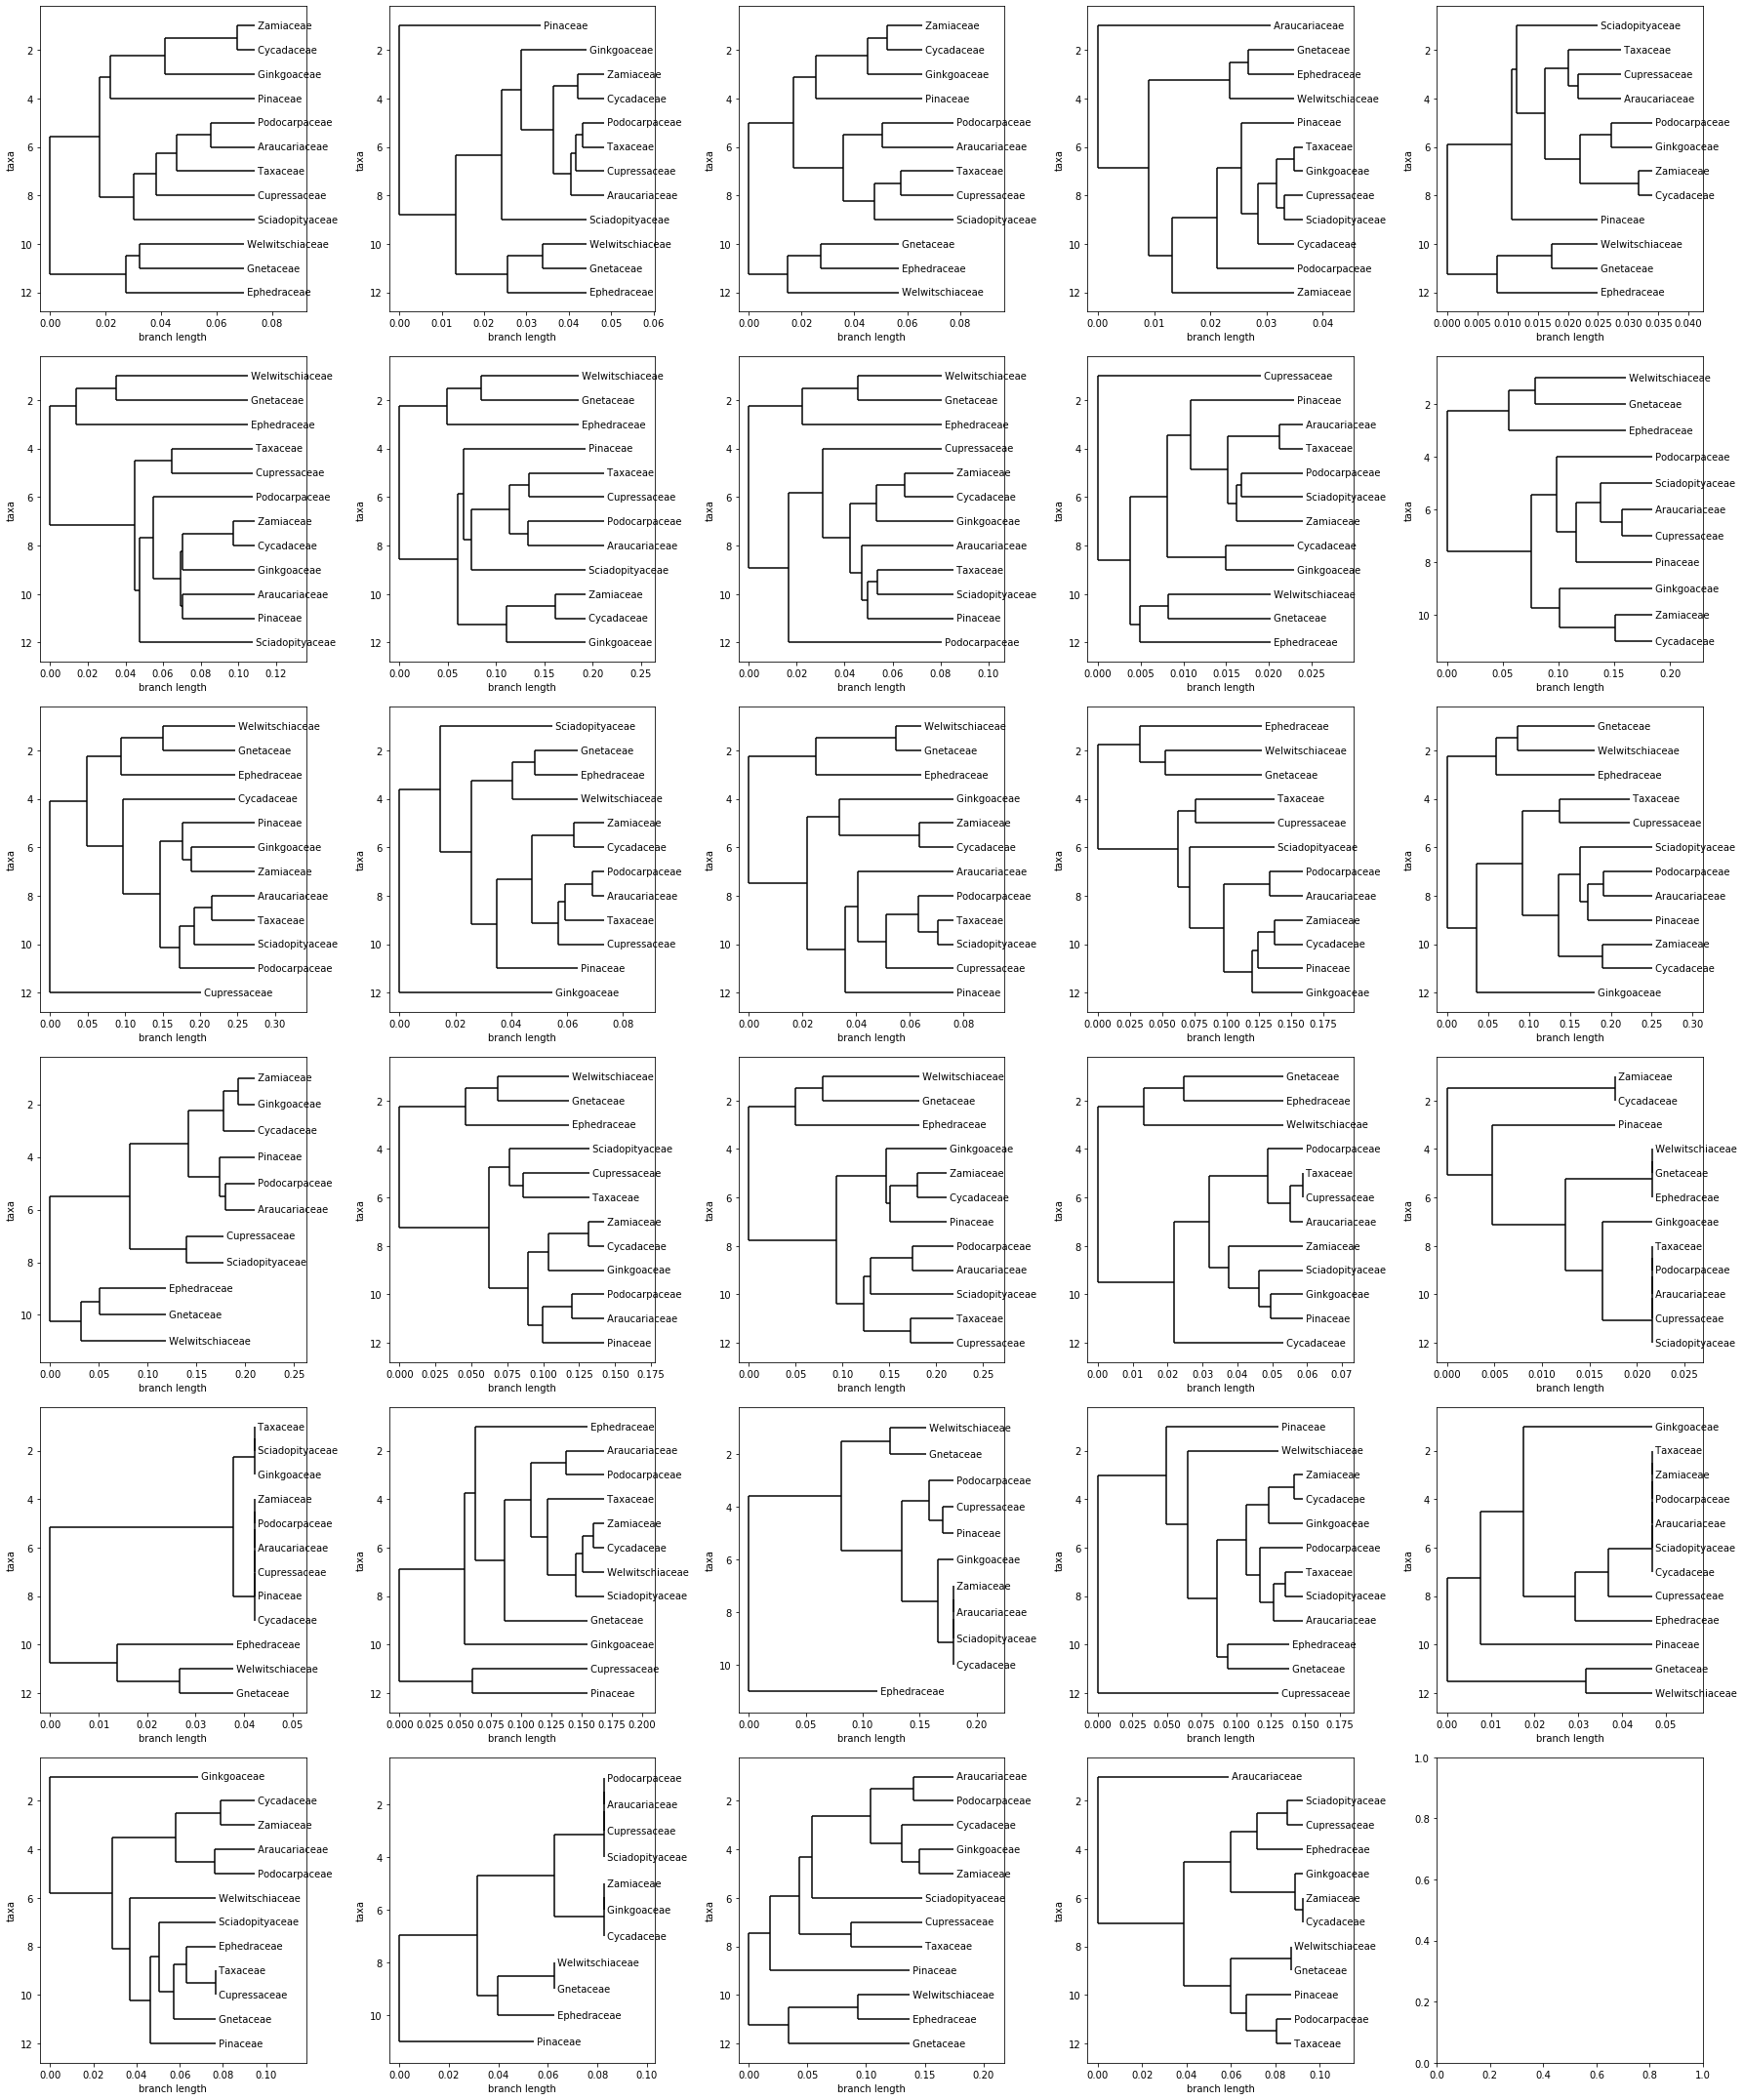

In [53]:
muscle_trees = list()
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(25, 30))
for i in range(1, n_seqs + 1):
    tree = build_tree_muscle(i)
    muscle_trees.append(tree)
    Phylo.draw(tree, label_func=label_display, axes = axs[(i - 1) // 5, (i - 1) % 5], do_show=False)
fig.tight_layout()
plt.show()

# Consensus Tree

#### Clustal

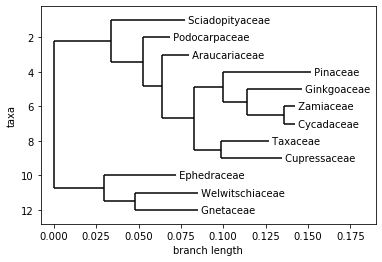

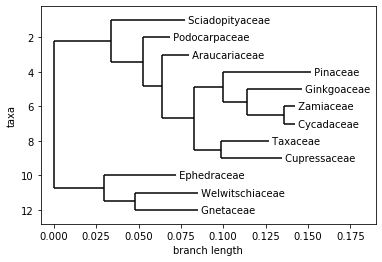

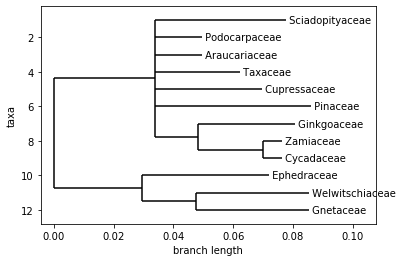

In [35]:
for cutoff in np.arange(0, 0.41, 0.2):
    clustal_majority_tree = majority_consensus(clustal_trees, cutoff)
    Phylo.draw(clustal_majority_tree, label_func=label_display, branch_labels=lambda x: "")

### Muscle

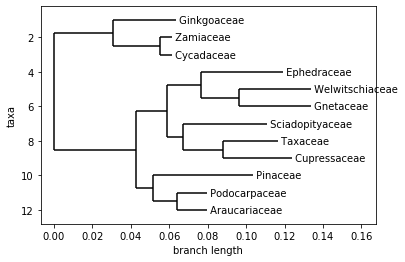

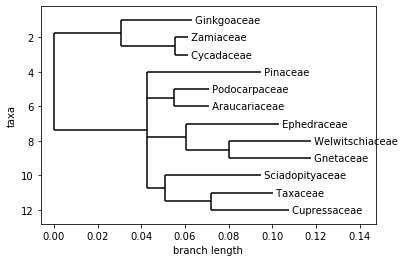

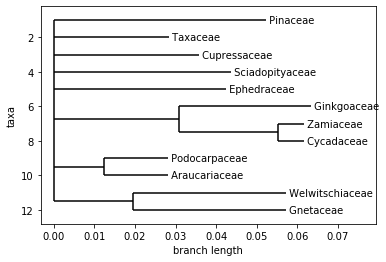

In [34]:
for cutoff in np.arange(0, 0.41, 0.2):
    muscle_majority_tree = majority_consensus(muscle_trees, cutoff)
    Phylo.draw(muscle_majority_tree, label_func=label_display, branch_labels=lambda x: "")